In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns

import tensorflow as tf
from sklearn import datasets
from tensorflow.keras.utils import to_categorical # 원-핫 인코딩을 사용하기 위해 keras.utils 모듈의  to_categorical을 import한다.
from sklearn.model_selection import train_test_split

***
분류 신경망을 이용해 와인 종류를 분류하는 모델을 만들어 본다.
***

In [2]:
# 일관된 결과값이 나오도록 numpy와 tensorflow의 seed를 설정한다. 
np.random.seed(0)
tf.random.set_seed(0)

***
분류 신경망에 사용할 데이터 준비
***

In [3]:
# 데이터 불러오기
raw_data = datasets.load_wine() # 사이킷런이 제공하는 와인 데이터를 불러온다.

# 피쳐, 레이블 데이터 저장
xData = raw_data.data # 피쳐 데이터를 저장한다.
yData = raw_data.target # 피쳐 데이터에 따른 레이블을 저장한다.
print(xData.shape, yData.shape)

# 총 13개의 피쳐가 있고, 이는 신경망을 생성할 때 사용된다.

# 클래스(레이블)의 종류 확인
# 클래스의 종류를 확인함으로써 분류 문제인지 회귀 문제인지 파악할 수 있고, 
# 분류 문제라면 몇가지 클래스로 구분되는지 알 수 있다. 
print(set(yData))

# 레이블 데이터 원-핫 인코딩
# to_categorical() 메소드는원-핫 인코딩을 실행한다.
yData_onehot = to_categorical(yData)

# 학습 데이터와 테스트 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(xData, yData_onehot, random_state=0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(178, 13) (178,)
{0, 1, 2}
(133, 13) (45, 13) (133, 3) (45, 3)


In [4]:
from tensorflow.keras.models import  Sequential # 시퀀스를 사용하기 신경망을 생성하기 위해 import 한다.
from tensorflow.keras.layers import Dense # 신경망에 추가할 완전 연결 레이어를 생성하기 위해 import 한다.  
from tensorflow.keras.layers import BatchNormalization # 배치 정규화 레이어를 생성하기 위해 import 한다. 
from tensorflow.keras.layers import Activation  # 활성화 함수 레이어를 생성하기 위해 import 한다.

***
시퀀스를 사용하는 분류 신경망 생성
***

In [5]:
# 분류 신경망 모델 학습에 사용되는 피쳐 갯수(n)와 클래스 갯수(c)를 저장한다.
n = x_train.shape[1]
c = len(set(yData))
print(f'피쳐 갯수(입력 데이터 1건(피쳐)의 차원) -> {n}, 클래스 갯수 -> {c} ')
epochs = 50

피쳐 갯수(입력 데이터 1건(피쳐)의 차원) -> 13, 클래스 갯수 -> 3 


In [6]:
# Sequential() 객체 선언 후 Sequential 모델에 add() 메소드로 레이어를 추가해 신경망을 만든다.
model = Sequential() # 시퀀스를 사용하는 신경망 모델을 만든다.

# 입력 레이어를 만든다.
# input_dim  속성으로 입력 데이터 1건(피쳐)의 차원, units 속성으로 레이어의 출력 차원을 지정한다.
#model.add(Dense(input_dim = n, units =  20)) # 신경망 모델의 입력 레이어를 추가한다.
#model.add(Activation("relu")) # 신경망 모델에 Relu 활성화 함수 레이어를 추가한다.
# Activation 레이어를 사용하지 않고 Dense 레이어의 activation 속성을 이용해서 활성화 함수를 지정할 수 있다. 
model.add(Dense( input_dim = n, units = 20, activation = "relu" ))
model.add(BatchNormalization()) # 신경망 모델에 배치 정규화 레이어를 추가한다.

#출력 레이어를 만든다.  
#분류 신경망은 구분해야할 클래스 갯수만큼 units 속을 지정한다.
#model.add(Dense( units =  c )) # 신경망 모델의 출력 레이어를 추가한다.
#model.add(Activation("softmax")) # 신경망 모델에 Relu 활성화 함수 레이어를 추가한다.
model.add(Dense( units = 3, activation = "softmax" ))


#Dense 레이어의 Param은 [(입력 차원;갯수;13 + 바이어스;1) x 출력 차원;갯수;20]으로 계산되고, 바이어스는 레이어당 1개이다.
#BatchNormalizetion의 Param은 [입력갯수 x 4]로 계산된다.
model.summary() # 신경망 모델의 구조를 확인한다.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                280       
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 423
Trainable params: 383
Non-trainable params: 40
_________________________________________________________________


***
신경망 모델 컴파일
***

In [7]:
# compile() 메소드로 생성한 신경망 모델을 컴파일 한다.
# 분류 신경망은 loss라는 속성에 손실함수(비용함수, 오차함수)를 지정할 때 레이블의 분류 결과 범주가 이진 분류일 경우 "binary_crossentropy"를 지정하고,
# 3개 이상의 클래스로 분류할 경우 "categorical_crossentropy"를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 "adam";Adam Optimizer)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics="Accuracy")

***
신경망 모델 학습
***

epoch -> 전체 학습 데이터셋 전체가 신경망을 통과하는 횟수   
iteration -> 1 epoch를 마치는데 필요한 미니 배치의 갯수  
batch_size -> 하나의 미니 배치에 속하는 데이터의 갯수  

In [8]:
# fit() 메소드로 학습 데이터, 원-핫 인코딩된  학습데이터에 따른 레이블, epoch 속성에 학습 횟수, batch-size 속성에 미니 배치 크기를 지정해 컴파일된 신경망 모델을 학습시킨다.
history = model.fit( x_train, y_train, epochs=epochs , batch_size=5)

Epoch 1/50
27/27 [==============================] - 1s 1ms/step - loss: 0.9456 - Accuracy: 0.1053 
Epoch 2/50
27/27 [==============================] - 0s 1ms/step - loss: 0.8163 - Accuracy: 0.2256
Epoch 3/50
27/27 [==============================] - 0s 1ms/step - loss: 0.7143 - Accuracy: 0.2857
Epoch 4/50
27/27 [==============================] - 0s 1ms/step - loss: 0.6705 - Accuracy: 0.3158
Epoch 5/50
27/27 [==============================] - 0s 1ms/step - loss: 0.5961 - Accuracy: 0.5940
Epoch 6/50
27/27 [==============================] - 0s 1ms/step - loss: 0.5642 - Accuracy: 0.5564
Epoch 7/50
27/27 [==============================] - 0s 1ms/step - loss: 0.5591 - Accuracy: 0.6466
Epoch 8/50
27/27 [==============================] - 0s 1ms/step - loss: 0.5190 - Accuracy: 0.6316
Epoch 9/50
27/27 [==============================] - 0s 1ms/step - loss: 0.5212 - Accuracy: 0.5940
Epoch 10/50
27/27 [==============================] - 0s 1ms/step - loss: 0.5113 - Accuracy: 0.5789
Epoch 11/50
27/27 

In [9]:
# 모델의 epoch 단계별로 정확도와 오차 확인
print(history.history["loss"][-1]) # 모델 실행 결과에서 오차만 얻어온다.
print(history.history["Accuracy"][-1]) #모델 실행 결과에서 정확도만 얻어온다.

0.20489788055419922
0.8872180581092834


In [10]:
# evaluate() 메소드로 테스트 데이터와 그에 따른 원-핫인코딩 된 테스트 레이블을 넘겨서  학습된 신경망을 평가한다.
print(model.evaluate(x_test, y_test))

2/2 [==============================] - 0s 2ms/step - loss: 0.1552 - Accuracy: 0.9556
[0.15519919991493225, 0.9555555582046509]


***
정확도 및 손실 정도 시각화
***

In [11]:
epoch = np.arange(1, (epochs + 1) )
loss = history.history["loss"]
accuracy = history.history["Accuracy"]

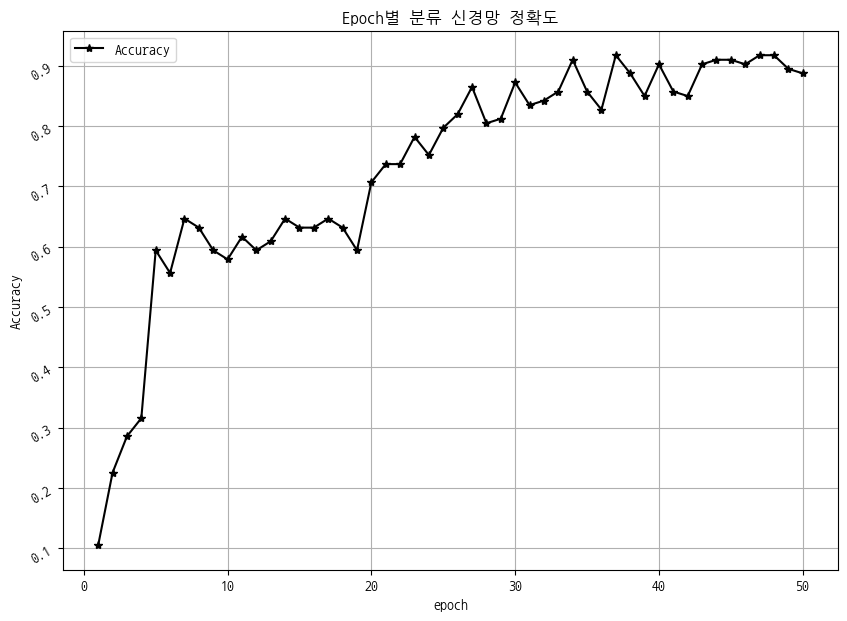

In [14]:
# 학습 정확도 시각화
plt.figure(figsize=[10, 7])
plt.plot(epoch, accuracy, "k*-" ,label="Accuracy")
plt.title("Epoch별 분류 신경망 정확도")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.yticks(rotation=30)
plt.show()
# 정확도 시각화 결과, epoch 진행 단계별로 전반적인 정확도가 상승하는 것을 볼 수 있다.

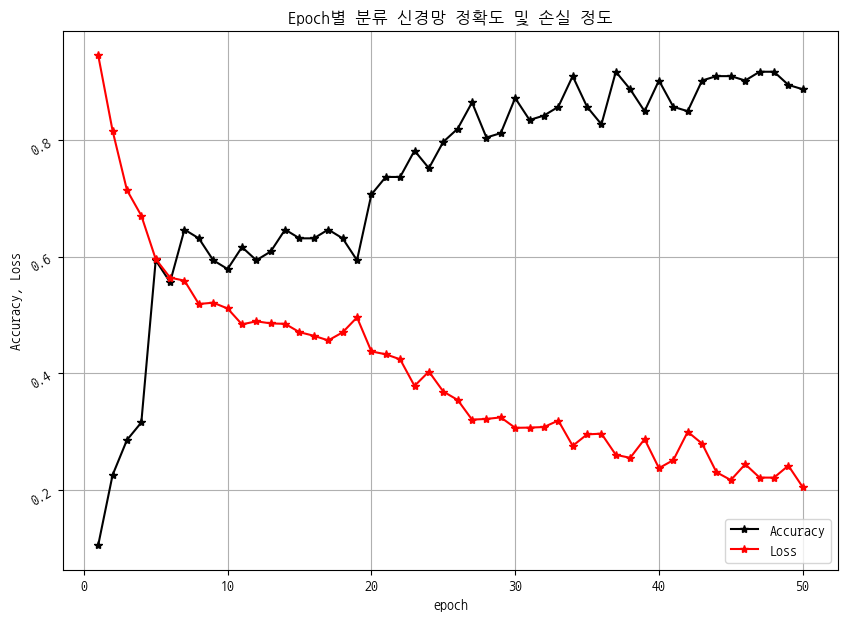

In [13]:
# 정확도와 손실 정도 시각화
plt.figure(figsize=[10, 7])
plt.plot(epoch, accuracy, "k*-" ,label="Accuracy")
plt.plot(epoch, loss,  "r*-", label="Loss")
plt.title("Epoch별 분류 신경망 정확도 및 손실 정도")
plt.xlabel("epoch")
plt.ylabel("Accuracy, Loss")
plt.legend()
plt.grid()
plt.yticks(rotation=30)
plt.show()
